In [ ]:
!pip install botorch
!pip install rdkit
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import rdkit
from rdkit import Chem, rdBase, DataStructs
from rdkit.Chem import rdmolfiles, rdmolops, AllChem, Draw, rdDepictor, Descriptors
from rdkit.Chem.Draw import IPythonConsole, rdMolDraw2D
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem.Fingerprints import FingerprintMols

from IPython.display import SVG
from IPython.display import HTML
from IPython.display import display

import torch
from botorch.models import SingleTaskGP
from gpytorch.kernels import ScaleKernel, RBFKernel, MaternKernel
from botorch.models.multitask import MultiTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from torch.optim import Adam
from collections import defaultdict
from tqdm import tqdm

#**Load Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
df = pd.read_csv('./drive/MyDrive/AI/Material Informatics (MI)/Polymer Cloud Point QSAR/Binary Polymer Solution Cloud Point Data/Data/Binary Polymer Solution Cloud Point Database.csv')
df['Polymer Mols'] = df['Polymer SMILES'].apply(lambda x : Chem.MolFromSmiles(x))
df['Solvent Mols'] = df['Solvent SMILES'].apply(lambda x : Chem.MolFromSmiles(x))
df = df.dropna(0)

In a future version of pandas all arguments of DataFrame.dropna will be keyword-only


In [ ]:
df

,Polymer,Polymer CAS,Polymer SMILES,Solvent,Solvent CAS,Solvent SMILES,Mw(Da),PDI,ϕ,w,P(Mpa),CP(°C),1-Phase,Ref.,Polymer Mols,Solvent Mols
0,polystyrene-d8,27732-42-9,[2H]C([2H])(*)C(*)([2H])c1c([2H])c([2H])c([2H]...,nitroethane,79-24-3,CC[N+](=O)[O-],27200,1.03,0.12780,0.1202,4.73,-3.97,positive,doi.org/10.1006/jcht.1999.0607,<rdkit.Chem.rdchem.Mol object at 0x7f1b4b6dff90>,<rdkit.Chem.rdchem.Mol object at 0x7f1b37aca7b0>
1,polystyrene-d8,27732-42-9,[2H]C([2H])(*)C(*)([2H])c1c([2H])c([2H])c([2H]...,nitroethane,79-24-3,CC[N+](=O)[O-],27200,1.03,0.17425,0.1644,4.44,-4.08,positive,doi.org/10.1006/jcht.1999.0607,<rdkit.Chem.rdchem.Mol object at 0x7f1b37ba52e0>,<rdkit.Chem.rdchem.Mol object at 0x7f1b37aca890>
2,polystyrene-d8,27732-42-9,[2H]C([2H])(*)C(*)([2H])c1c([2H])c([2H])c([2H]...,nitroethane,79-24-3,CC[N+](=O)[O-],27200,1.03,0.19746,0.1866,0.48,-3.87,positive,doi.org/10.1006/jcht.1999.0607,<rdkit.Chem.rdchem.Mol object at 0x7f1b37ba5190>,<rdkit.Chem.rdchem.Mol object at 0x7f1b37aca820>
3,polystyrene-d8,27732-42-9,[2H]C([2H])(*)C(*)([2H])c1c([2H])c([2H])c([2H]...,propionitrile,107-12-0,CCC#N,26700,1.05,0.09173,0.1100,2.28,172.28,negative,doi.org/10.1021/ma9517308,<rdkit.Chem.rdchem.Mol object at 0x7f1b37ba5350>,<rdkit.Chem.rdchem.Mol object at 0x7f1b37aca900>
4,polystyrene-d8,27732-42-9,[2H]C([2H])(*)C(*)([2H])c1c([2H])c([2H])c([2H]...,nitroethane,79-24-3,CC[N+](=O)[O-],85200,1.02,0.11958,0.1124,0.25,14.99,positive,doi.org/10.1006/jcht.1999.0607,<rdkit.Chem.rdchem.Mol object at 0x7f1b37ba53c0>,<rdkit.Chem.rdchem.Mol object at 0x7f1b37aca970>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6519,"poly(1,3-dioxolane)",25067-64-5,*OCOCC*,water,7732-18-5,O,50000,1.50,0.44220,0.5056,0.10,63.14,negative,doi.org/10.1021/ma00047a022,<rdkit.Chem.rdchem.Mol object at 0x7f1b37aca4a0>,<rdkit.Chem.rdchem.Mol object at 0x7f1b37a03970>
6520,"poly(1,3-dioxolane)",25067-64-5,*OCOCC*,water,7732-18-5,O,50000,1.50,0.09225,0.1159,0.10,71.08,negative,doi.org/10.1021/ma00047a022,<rdkit.Chem.rdchem.Mol object at 0x7f1b37aca510>,<rdkit.Chem.rdchem.Mol object at 0x7f1b37a039e0>
6521,"poly(1,3-dioxolane)",25067-64-5,*OCOCC*,water,7732-18-5,O,50000,1.50,0.11156,0.1394,0.10,72.63,negative,doi.org/10.1021/ma00047a022,<rdkit.Chem.rdchem.Mol object at 0x7f1b37aca580>,<rdkit.Chem.rdchem.Mol object at 0x7f1b37a03a50>
6522,"poly(1,3-dioxolane)",25067-64-5,*OCOCC*,water,7732-18-5,O,50000,1.50,0.34850,0.4083,0.10,73.50,negative,doi.org/10.1021/ma00047a022,<rdkit.Chem.rdchem.Mol object at 0x7f1b37aca5f0>,<rdkit.Chem.rdchem.Mol object at 0x7f1b37a03ac0>


In [ ]:
#Remove rows with polyetyrene-d8 (includes deuterium)
index_d_droped = df[(df["Polymer"] == "polystyrene-d8") | (df["Solvent"] == "nitroethane-d5")].index
df_new = df.drop(index_d_droped)
df_new

,Polymer,Polymer CAS,Polymer SMILES,Solvent,Solvent CAS,Solvent SMILES,Mw(Da),PDI,ϕ,w,P(Mpa),CP(°C),1-Phase,Ref.,Polymer Mols,Solvent Mols
395,polystyrene,9003-53-6,*C(C*)c1ccccc1,methylcyclohexane,108-87-2,CC1CCCCC1,17500,1.06,0.11406,0.15000,82.81,21.34,positive,doi.org/10.1002/macp.1994.021950233,<rdkit.Chem.rdchem.Mol object at 0x7f1b37b8a190>,<rdkit.Chem.rdchem.Mol object at 0x7f1b37ad76d0>
396,polystyrene,9003-53-6,*C(C*)c1ccccc1,methylcyclohexane,108-87-2,CC1CCCCC1,17500,1.06,0.18196,0.23366,80.00,21.18,positive,doi.org/10.1002/macp.1994.021950233,<rdkit.Chem.rdchem.Mol object at 0x7f1b37b8a200>,<rdkit.Chem.rdchem.Mol object at 0x7f1b37ad7740>
397,polystyrene,9003-53-6,*C(C*)c1ccccc1,cyclohexanol,108-93-0,OC1CCCCC1,78800,1.12,0.00632,0.00700,0.10,73.99,positive,doi.org/10.1021/je0504865,<rdkit.Chem.rdchem.Mol object at 0x7f1b37b8a270>,<rdkit.Chem.rdchem.Mol object at 0x7f1b37ad77b0>
398,polystyrene,9003-53-6,*C(C*)c1ccccc1,methylcyclopentane,96-37-7,CC1CCCC1,22100,1.03,0.11401,0.15300,1.02,27.42,positive,doi.org/10.1021/ma00107a011,<rdkit.Chem.rdchem.Mol object at 0x7f1b37b8a2e0>,<rdkit.Chem.rdchem.Mol object at 0x7f1b37ad7820>
399,polystyrene,9003-53-6,*C(C*)c1ccccc1,nitroethane,79-24-3,CC[N+](=O)[O-],13500,1.06,0.17990,0.17990,4.35,6.08,positive,doi.org/10.1006/jcht.1999.0607,<rdkit.Chem.rdchem.Mol object at 0x7f1b37b8a350>,<rdkit.Chem.rdchem.Mol object at 0x7f1b37ad7890>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6519,"poly(1,3-dioxolane)",25067-64-5,*OCOCC*,water,7732-18-5,O,50000,1.50,0.44220,0.50560,0.10,63.14,negative,doi.org/10.1021/ma00047a022,<rdkit.Chem.rdchem.Mol object at 0x7f1b37aca4a0>,<rdkit.Chem.rdchem.Mol object at 0x7f1b37a03970>
6520,"poly(1,3-dioxolane)",25067-64-5,*OCOCC*,water,7732-18-5,O,50000,1.50,0.09225,0.11590,0.10,71.08,negative,doi.org/10.1021/ma00047a022,<rdkit.Chem.rdchem.Mol object at 0x7f1b37aca510>,<rdkit.Chem.rdchem.Mol object at 0x7f1b37a039e0>
6521,"poly(1,3-dioxolane)",25067-64-5,*OCOCC*,water,7732-18-5,O,50000,1.50,0.11156,0.13940,0.10,72.63,negative,doi.org/10.1021/ma00047a022,<rdkit.Chem.rdchem.Mol object at 0x7f1b37aca580>,<rdkit.Chem.rdchem.Mol object at 0x7f1b37a03a50>
6522,"poly(1,3-dioxolane)",25067-64-5,*OCOCC*,water,7732-18-5,O,50000,1.50,0.34850,0.40830,0.10,73.50,negative,doi.org/10.1021/ma00047a022,<rdkit.Chem.rdchem.Mol object at 0x7f1b37aca5f0>,<rdkit.Chem.rdchem.Mol object at 0x7f1b37a03ac0>


# **Descriptor Calculation**

In [ ]:
class Morgan_fingerprint(): #From Chen

    def __init__(self,mols):
        self.mols = mols
        self.bitExamples = {}
        self.keepMols = {}
        return
    
    def calculate(self,radius=2,bits=1024,vector_type="count",unhash=False):
        if vector_type not in ["count","bit"]: 
            return
        elif vector_type=="bit":
            unhash=False
            fp_all = defaultdict()
            
        mols = self.mols
        self.bits = bits
        self.radius = radius
        self.bitI_morgan =  {}
        morgan_count = defaultdict(lambda:[0]*len(mols))
        for idx,mol in enumerate(tqdm(mols)):
            self.bitI_morgan[idx] = {}
            if unhash==True:
                fp_morgan = AllChem.GetMorganFingerprint(mol, radius, bitInfo=self.bitI_morgan[idx])
            else:
                fp_morgan = AllChem.GetMorganFingerprintAsBitVect(mol, radius, 
                                                                  bitInfo=self.bitI_morgan[idx],nBits=bits)
                if vector_type=="bit":
                    arr = np.zeros((1,))
                    DataStructs.ConvertToNumpyArray(fp_morgan, arr)
                    fp_all[idx]= arr
            for key in list(self.bitI_morgan[idx].keys()):
                morgan_count["{}".format(key)][idx]=len(self.bitI_morgan[idx][key])
                #generate bit examples for visualization
                self.bitExamples[key] = idx
                self.keepMols[idx]=mol
                
        if vector_type=="bit": return pd.DataFrame.from_dict(fp_all).T #Bit type       
        return pd.DataFrame.from_dict(morgan_count)

    def visualize(self,bit_name,molSize=(250,200),verbose=True):
        bitId = int(bit_name)
        if verbose==True: print ('bit %s'%bitId)
        zid = self.bitExamples[bitId]
        mol = self.keepMols[zid]
        aid,rad = self.bitI_morgan[zid][bitId][0]
        pic1,svg  = getSubstructDepiction(mol,aid,rad,molSize=molSize)
        pic2 = Draw.DrawMorganBit(mol,bitId,self.bitI_morgan[zid])
        #display(pic)
        return pic1,pic2,svg

#for visualization #From Chen
def _prepareMol(mol,kekulize):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    return mc

def moltosvg(mol,molSize=(450,200),kekulize=True,drawer=None,**kwargs):
    mc = _prepareMol(mol,kekulize)
    if drawer is None:
        drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc,**kwargs)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    # It seems that the svg renderer used doesn't quite hit the spec.
    # Here are some fixes to make it work in the notebook, although I think
    # the underlying issue needs to be resolved at the generation step
    #with open('morgan bits/%s.svg'%bitId, 'w') as f:
    #    f.write(svg)
    return SVG(svg.replace('svg:','')),svg 

def getSubstructDepiction(mol,atomID,radius,molSize=(450,200)):
    if radius>0:
        env = Chem.FindAtomEnvironmentOfRadiusN(mol,radius,atomID)
        atomsToUse=[]
        for b in env:
            atomsToUse.append(mol.GetBondWithIdx(b).GetBeginAtomIdx())
            atomsToUse.append(mol.GetBondWithIdx(b).GetEndAtomIdx())
        atomsToUse = list(set(atomsToUse))       
    else:
        atomsToUse = [atomID]
        env=None
    return moltosvg(mol,molSize=molSize,highlightAtoms=atomsToUse)

In [ ]:
#MF for polymer
mf_poly = Morgan_fingerprint(df_new["Polymer Mols"].values)
fp_poly = mf_poly.calculate(radius=2,bits=1024,vector_type="count",unhash=False)
fp_poly = fp_poly.dropna(1)

#MF for solvent
mf_sol = Morgan_fingerprint(df_new["Solvent Mols"].values)
fp_sol = mf_sol.calculate(radius=2,bits=1024,vector_type="count",unhash=False)
fp_sol = fp_sol.dropna(1)

100%|██████████| 4833/4833 [00:00<00:00, 8250.07it/s]
In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
100%|██████████| 4833/4833 [00:00<00:00, 32760.64it/s]
In a future version of pandas all arguments of DataFrame.dropna will be keyword-only


In [ ]:
fp_poly.head()

,1,64,80,170,175,226,247,341,356,389,...,566,587,863,875,103,578,658,770,932,968
0,1,3,1,1,2,2,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,3,1,1,2,2,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,3,1,1,2,2,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,3,1,1,2,2,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1,3,1,1,2,2,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
fp_sol.head()

,2,4,33,117,124,285,301,890,926,973,...,512,781,831,378,656,777,386,799,896,709
0,1,3,1,2,1,1,2,2,5,1,...,0,0,0,0,0,0,0,0,0,0
1,1,3,1,2,1,1,2,2,5,1,...,0,0,0,0,0,0,0,0,0,0
2,1,3,0,0,0,0,2,2,5,0,...,0,0,0,0,0,0,0,0,0,0
3,0,2,1,2,1,1,2,2,4,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# **Descriptor Combination (Poly_MF/Sol_MF)**

In [ ]:
fp_sol.columns

Index(['2', '4', '33', '117', '124', '285', '301', '890', '926', '973',
       ...
       '512', '781', '831', '378', '656', '777', '386', '799', '896', '709'],
      dtype='object', length=173)

In [ ]:
fp_sol_new = fp_sol.rename(columns=lambda n: n + '*')

In [ ]:
fp_sol_new

,2*,4*,33*,117*,124*,285*,301*,890*,926*,973*,...,512*,781*,831*,378*,656*,777*,386*,799*,896*,709*
0,1,3,1,2,1,1,2,2,5,1,...,0,0,0,0,0,0,0,0,0,0
1,1,3,1,2,1,1,2,2,5,1,...,0,0,0,0,0,0,0,0,0,0
2,1,3,0,0,0,0,2,2,5,0,...,0,0,0,0,0,0,0,0,0,0
3,0,2,1,2,1,1,2,2,4,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4828,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4829,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4830,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4831,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
fp_com_mf = pd.concat([fp_poly, fp_sol_new, df_new.reset_index(drop=True)[["Mw(Da)", "PDI", "ϕ", "w", "P(Mpa)", "1-Phase", "CP(°C)"]]], axis=1)
fp_com_mf

,1,64,80,170,175,226,247,341,356,389,...,799*,896*,709*,Mw(Da),PDI,ϕ,w,P(Mpa),1-Phase,CP(°C)
0,1,3,1,1,2,2,1,1,1,1,...,0,0,0,17500,1.06,0.11406,0.15000,82.81,positive,21.34
1,1,3,1,1,2,2,1,1,1,1,...,0,0,0,17500,1.06,0.18196,0.23366,80.00,positive,21.18
2,1,3,1,1,2,2,1,1,1,1,...,0,0,0,78800,1.12,0.00632,0.00700,0.10,positive,73.99
3,1,3,1,1,2,2,1,1,1,1,...,0,0,0,22100,1.03,0.11401,0.15300,1.02,positive,27.42
4,1,3,1,1,2,2,1,1,1,1,...,0,0,0,13500,1.06,0.17990,0.17990,4.35,positive,6.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4828,0,0,3,0,0,2,1,0,0,0,...,0,0,0,50000,1.50,0.44220,0.50560,0.10,negative,63.14
4829,0,0,3,0,0,2,1,0,0,0,...,0,0,0,50000,1.50,0.09225,0.11590,0.10,negative,71.08
4830,0,0,3,0,0,2,1,0,0,0,...,0,0,0,50000,1.50,0.11156,0.13940,0.10,negative,72.63
4831,0,0,3,0,0,2,1,0,0,0,...,0,0,0,50000,1.50,0.34850,0.40830,0.10,negative,73.50


In [ ]:
#For 1-Phase, use LabelEncoder to transfer str to int.
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
LE.fit_transform(fp_com_mf["1-Phase"])

fp_com_mf["1-Phase"] = LE.fit_transform(fp_com_mf["1-Phase"])
fp_com_mf

,1,64,80,170,175,226,247,341,356,389,...,799*,896*,709*,Mw(Da),PDI,ϕ,w,P(Mpa),1-Phase,CP(°C)
0,1,3,1,1,2,2,1,1,1,1,...,0,0,0,17500,1.06,0.11406,0.15000,82.81,1,21.34
1,1,3,1,1,2,2,1,1,1,1,...,0,0,0,17500,1.06,0.18196,0.23366,80.00,1,21.18
2,1,3,1,1,2,2,1,1,1,1,...,0,0,0,78800,1.12,0.00632,0.00700,0.10,1,73.99
3,1,3,1,1,2,2,1,1,1,1,...,0,0,0,22100,1.03,0.11401,0.15300,1.02,1,27.42
4,1,3,1,1,2,2,1,1,1,1,...,0,0,0,13500,1.06,0.17990,0.17990,4.35,1,6.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4828,0,0,3,0,0,2,1,0,0,0,...,0,0,0,50000,1.50,0.44220,0.50560,0.10,0,63.14
4829,0,0,3,0,0,2,1,0,0,0,...,0,0,0,50000,1.50,0.09225,0.11590,0.10,0,71.08
4830,0,0,3,0,0,2,1,0,0,0,...,0,0,0,50000,1.50,0.11156,0.13940,0.10,0,72.63
4831,0,0,3,0,0,2,1,0,0,0,...,0,0,0,50000,1.50,0.34850,0.40830,0.10,0,73.50


In [ ]:
#Dropping "1-Phase"
f_dropped = fp_com_mf.drop("1-Phase", axis=1)

Feature scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
f_std = f_dropped.copy()
f_std.iloc[:, :-1] = scaler.fit_transform(f_std.iloc[:, :-1])

In [ ]:
print(f_std.shape)
f_std.head()

(4833, 306)


,1,64,80,170,175,226,247,341,356,389,...,386*,799*,896*,709*,Mw(Da),PDI,ϕ,w,P(Mpa),CP(°C)
0,0.415898,0.759158,-0.28004,0.659527,0.759158,0.0,-0.273039,0.81713,0.62692,0.759158,...,-0.045535,-0.085409,-0.085409,-0.089022,-0.531646,-0.548048,0.036676,0.145899,5.774263,21.34
1,0.415898,0.759158,-0.28004,0.659527,0.759158,0.0,-0.273039,0.81713,0.62692,0.759158,...,-0.045535,-0.085409,-0.085409,-0.089022,-0.531646,-0.548048,0.657195,0.846006,5.564014,21.18
2,0.415898,0.759158,-0.28004,0.659527,0.759158,0.0,-0.273039,0.81713,0.62692,0.759158,...,-0.045535,-0.085409,-0.085409,-0.089022,-0.323328,-0.484995,-0.947929,-1.050794,-0.414228,73.99
3,0.415898,0.759158,-0.28004,0.659527,0.759158,0.0,-0.273039,0.81713,0.62692,0.759158,...,-0.045535,-0.085409,-0.085409,-0.089022,-0.516014,-0.579574,0.036219,0.171004,-0.345393,27.42
4,0.415898,0.759158,-0.28004,0.659527,0.759158,0.0,-0.273039,0.81713,0.62692,0.759158,...,-0.045535,-0.085409,-0.085409,-0.089022,-0.545239,-0.548048,0.638369,0.396117,-0.096237,6.08


# **Model Building**

In [ ]:
from sklearn.model_selection import train_test_split

X = f_std.iloc[:, :-1].values
y = f_std.iloc[:, -1].values

#Seperating literature data to training and validation data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)


In [ ]:
# A list for the evaluation result
rmse_sum = {}
r2_sum = {}

## Lasso

In [ ]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)

Lasso(alpha=0.1)

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

R_square_train = r2_score(y_train, lasso.predict(X_train))
RMSE_train = mean_squared_error(y_train, lasso.predict(X_train), squared=False)
R_square_test = r2_score(y_test, lasso.predict(X_test))
RMSE_test = mean_squared_error(y_test, lasso.predict(X_test), squared=False)

print(f'R_square(Train): {R_square_train}\nRMSE(Train): {RMSE_train}\n')
print(f'R_square(Test): {R_square_test}\nRMSE(Test): {RMSE_test}')

R_square(Train): 0.6197516880640994
RMSE(Train): 47.746482166122156

R_square(Test): 0.6066105248784086
RMSE(Test): 47.76794925641381


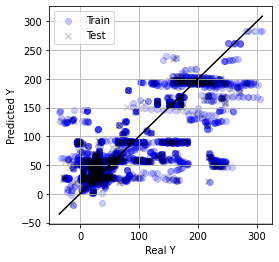

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.scatter(y_train, lasso.predict(X_train), alpha=0.2, c="blue", label='Train')
plt.scatter(y_test, lasso.predict(X_test), alpha=0.2, c="black", marker='x', label='Test')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c="black")
plt.legend()
plt.grid()
plt.xlabel("Real Y")
plt.ylabel("Predicted Y")
plt.show()

In [ ]:
rmse_sum['Linear Regression(Lasso)'] = [RMSE_train, RMSE_test] 
r2_sum['Linear Regression(Lasso)'] = [R_square_train, R_square_test] 

## Ridge

In [ ]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=0.1)
ridge.fit(X_train, y_train)

Ridge(alpha=0.1)

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

R_square_train = r2_score(y_train, ridge.predict(X_train))
RMSE_train = mean_squared_error(y_train, ridge.predict(X_train), squared=False)
R_square_test = r2_score(y_test, ridge.predict(X_test))
RMSE_test = mean_squared_error(y_test, ridge.predict(X_test), squared=False)

print(f'R_square(Train): {R_square_train}\nRMSE(Train): {RMSE_train}\n')
print(f'R_square(Test): {R_square_test}\nRMSE(Test): {RMSE_test}')

R_square(Train): 0.6231441864430298
RMSE(Train): 47.53301274779356

R_square(Test): 0.609905167811511
RMSE(Test): 47.56750002604898


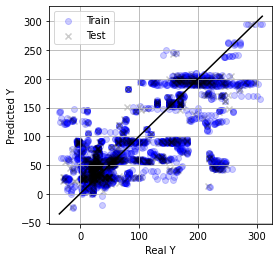

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.scatter(y_train, ridge.predict(X_train), alpha=0.2, c="blue", label='Train')
plt.scatter(y_test, ridge.predict(X_test), alpha=0.2, c="black", marker='x', label='Test')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c="black")
plt.legend()
plt.grid()
plt.xlabel("Real Y")
plt.ylabel("Predicted Y")
plt.show()

In [ ]:
rmse_sum['Linear Regression(Ridge)'] = [RMSE_train, RMSE_test] 
r2_sum['Linear Regression(Ridge)'] = [R_square_train, R_square_test] 

## ElasticNet

In [ ]:
from sklearn.linear_model import ElasticNet
EN = ElasticNet(alpha=0.1)
EN.fit(X_train, y_train)

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.453e+05, tolerance: 2.318e+03


ElasticNet(alpha=0.1)

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

R_square_train = r2_score(y_train, EN.predict(X_train))
RMSE_train = mean_squared_error(y_train, EN.predict(X_train), squared=False)
R_square_test = r2_score(y_test, EN.predict(X_test))
RMSE_test = mean_squared_error(y_test, EN.predict(X_test), squared=False)

print(f'R_square(Train): {R_square_train}\nRMSE(Train): {RMSE_train}\n')
print(f'R_square(Test): {R_square_test}\nRMSE(Test): {RMSE_test}')

R_square(Train): 0.6173248068166257
RMSE(Train): 47.898607418504355

R_square(Test): 0.6051827733074876
RMSE(Test): 47.85455426198492


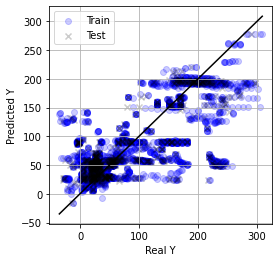

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.scatter(y_train, EN.predict(X_train), alpha=0.2, c="blue", label='Train')
plt.scatter(y_test, EN.predict(X_test), alpha=0.2, c="black", marker='x', label='Test')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c="black")
plt.legend()
plt.grid()
plt.xlabel("Real Y")
plt.ylabel("Predicted Y")
plt.show()

In [ ]:
rmse_sum['Linear Regression(ElasticNet)'] = [RMSE_train, RMSE_test] 
r2_sum['Linear Regression(ElasticNet)'] = [R_square_train, R_square_test] 

## RF

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

R_square_train = r2_score(y_train, rf.predict(X_train))
RMSE_train = mean_squared_error(y_train, rf.predict(X_train), squared=False)
R_square_test = r2_score(y_test, rf.predict(X_test))
RMSE_test = mean_squared_error(y_test, rf.predict(X_test), squared=False)

print(f'R_square(Train): {R_square_train}\nRMSE(Train): {RMSE_train}\n')
print(f'R_square(Test): {R_square_test}\nRMSE(Test): {RMSE_test}')

R_square(Train): 0.9013503164832601
RMSE(Train): 24.319552551953038

R_square(Test): 0.6957536701516542
RMSE(Test): 42.00857043289645


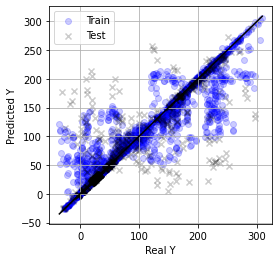

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.scatter(y_train, rf.predict(X_train), alpha=0.2, c="blue", label='Train')
plt.scatter(y_test, rf.predict(X_test), alpha=0.2, c="black", marker='x', label='Test')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c="black")
plt.legend()
plt.grid()
plt.xlabel("Real Y")
plt.ylabel("Predicted Y")
plt.show()

In [ ]:
rmse_sum['RF'] = [RMSE_train, RMSE_test]
r2_sum['RF'] = [R_square_train, R_square_test] 

## SVR

In [ ]:
# from sklearn.svm import SVR
# svr = SVR()
# svr.fit(X_train, y_train)

In [ ]:
# from sklearn.metrics import r2_score
# from sklearn.metrics import mean_squared_error

# R_square_train = r2_score(y_train, svr.predict(X_train))
# RMSE_train = mean_squared_error(y_train, svr.predict(X_train), squared=False)
# R_square_test = r2_score(y_test, svr.predict(X_test))
# RMSE_test = mean_squared_error(y_test, svr.predict(X_test), squared=False)

# print(f'R_square(Train): {R_square_train}\nRMSE(Train): {RMSE_train}\n')
# print(f'R_square(Test): {R_square_test}\nRMSE(Test): {RMSE_test}')

In [ ]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# plt.figure(figsize=(4,4))
# plt.scatter(y_train, svr.predict(X_train), alpha=0.2, c="blue", label='Train')
# plt.scatter(y_test, svr.predict(X_test), alpha=0.2, c="black", marker='x', label='Test')
# plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c="black")
# plt.legend()
# plt.grid()
# plt.xlabel("Real Y")
# plt.ylabel("Predicted Y")
# plt.show()

In [ ]:
# rmse_sum['SVR'] = [RMSE_train, RMSE_test] 
# r2_sum['SVR'] = [R_square_train, R_square_test] 

## LGB

In [ ]:
import lightgbm as lgb
lgb_reg = lgb.LGBMRegressor()
lgb_reg.fit(X_train, y_train)

LGBMRegressor()

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

R_square_train = r2_score(y_train, lgb_reg.predict(X_train))
RMSE_train = mean_squared_error(y_train, lgb_reg.predict(X_train), squared=False)
R_square_test = r2_score(y_test, lgb_reg.predict(X_test))
RMSE_test = mean_squared_error(y_test, lgb_reg.predict(X_test), squared=False)

print(f'R_square(Train): {R_square_train}\nRMSE(Train): {RMSE_train}\n')
print(f'R_square(Test): {R_square_test}\nRMSE(Test): {RMSE_test}')

R_square(Train): 0.8397453853912358
RMSE(Train): 30.99652471581647

R_square(Test): 0.7807092431798011
RMSE(Test): 35.66443857401451


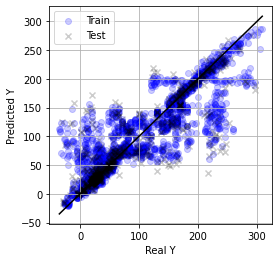

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.scatter(y_train, lgb_reg.predict(X_train), alpha=0.2, c="blue", label='Train')
plt.scatter(y_test, lgb_reg.predict(X_test), alpha=0.2, c="black", marker='x', label='Test')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c="black")
plt.legend()
plt.grid()
plt.xlabel("Real Y")
plt.ylabel("Predicted Y")
plt.show()

In [ ]:
rmse_sum['LGB'] = [RMSE_train, RMSE_test] 
r2_sum['LGB'] = [R_square_train, R_square_test] 

## GP (BoTorch)

In [ ]:
from sklearn.model_selection import train_test_split

X = f.iloc[:, :-1].values
y = f.iloc[:, -1].values

#Seperating literature data to training and validation data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)


In [ ]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler

# X must be in the range=(0, 1)
# use MinMaxScaler to transform features
mmscaler = MinMaxScaler()
X_train_mm = mmscaler.fit_transform(X_train)
X_test_mm = mmscaler.transform(X_test)


X_train_tensor = torch.from_numpy(np.array(X_train_mm))
X_test_tensor = torch.from_numpy(np.array(X_test_mm))


# Y must be in the range=(-1, 1)
y_scaler = StandardScaler()

y_train_s = y_scaler.fit_transform(y_train.reshape(-1, 1))
y_test_s = y_scaler.transform(y_test.reshape(-1, 1))

y_train_tensor = torch.from_numpy(np.array(y_train_s))
y_test_tensor = torch.from_numpy(np.array(y_test_s))

In [ ]:
kernel = RBFKernel(ard_num_dims=X.shape[1])

gp = SingleTaskGP(X_train_tensor, y_train_tensor, covar_module=kernel)
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)

fit_gpytorch_model(mll)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): RBFKernel(
      (raw_lengthscale_constraint): Positive()
      (distance_module): Distance()
    )
  )
)

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

y_train_pred = gp.posterior(X_train_tensor).mean.detach().numpy().copy()
y_train_var = gp.posterior(X_train_tensor).variance.detach().numpy().copy()

y_test_pred = gp.posterior(X_test_tensor).mean.detach().numpy().copy()
y_test_var = gp.posterior(X_test_tensor).variance.detach().numpy().copy()

R_square_train = r2_score(y_train_s, y_train_pred)
RMSE_train = mean_squared_error(y_scaler.inverse_transform(y_train_s), y_scaler.inverse_transform(y_train_pred), squared=False)
R_square_test = r2_score(y_test_s, y_test_pred)
RMSE_test = mean_squared_error(y_scaler.inverse_transform(y_test_s), y_scaler.inverse_transform(y_test_pred), squared=False)

print(f'R_square(Train): {R_square_train}\nRMSE(Train): {RMSE_train}\n')
print(f'R_square(Test): {R_square_test}\nRMSE(Test): {RMSE_test}')

R_square(Train): 0.7928880255946902
RMSE(Train): 35.23792577919184

R_square(Test): 0.7682003070829169
RMSE(Test): 36.66753006349593


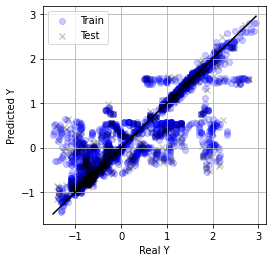

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.scatter(y_train_s, y_train_pred, alpha=0.2, c="blue", label='Train')
plt.scatter(y_test_s, y_test_pred, alpha=0.2, c="black", marker='x', label='Test')
plt.plot([y_train_s.min(), y_train_s.max()], [y_train_s.min(), y_train_s.max()], c="black")
plt.legend()
plt.grid()
plt.xlabel("Real Y")
plt.ylabel("Predicted Y")
plt.show()

In [ ]:
rmse_sum['GP'] = [RMSE_train, RMSE_test] 
r2_sum['GP'] = [R_square_train, R_square_test] 

# **Summary**

In [ ]:
summary = pd.DataFrame(rmse_sum, index=['Train', 'Test'])
summary.style.set_caption("Table of RMSE")

,Linear Regression(Lasso),Linear Regression(Ridge),Linear Regression(ElasticNet),RF,LGB,GP
Train,47.746482,47.533013,47.898607,24.319553,30.996525,35.237926
Test,47.767949,47.567500,47.854554,42.008570,35.664439,36.667530


In [ ]:
summary = pd.DataFrame(r2_sum, index=['Train', 'Test'])
summary.style.set_caption("Table of R square")

,Linear Regression(Lasso),Linear Regression(Ridge),Linear Regression(ElasticNet),RF,LGB,GP
Train,0.619752,0.623144,0.617325,0.901350,0.839745,0.792888
Test,0.606611,0.609905,0.605183,0.695754,0.780709,0.768200


# **Feature Importance**

Text(0.5, 0, 'Feature Importance')

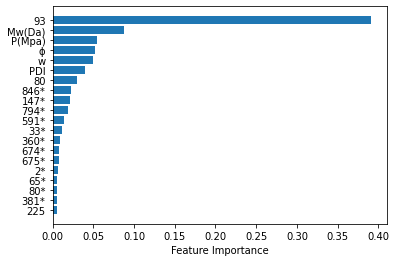

In [ ]:
model = rf
sort = model.feature_importances_.argsort()
plt.barh(f_std.iloc[:, :-1].columns[sort].astype(str)[-20:], model.feature_importances_[sort][-20:])
plt.xlabel("Feature Importance")

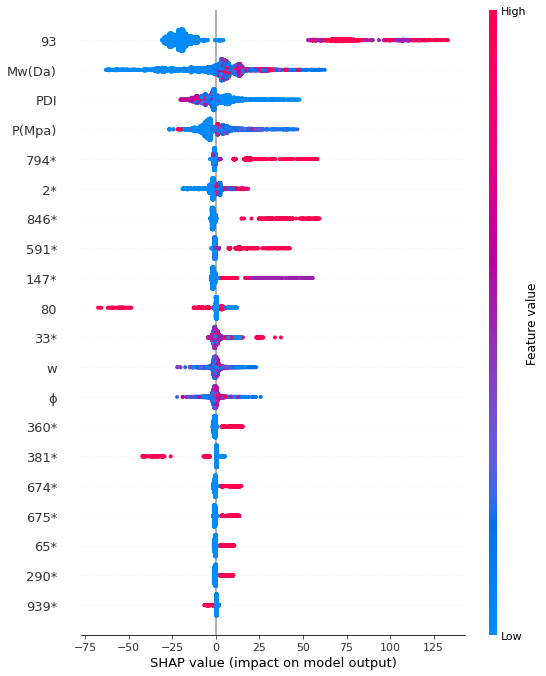

In [ ]:
import shap

shap.initjs()
explainer = shap.TreeExplainer(model=rf, feature_perturbation='tree_path_dependent', model_output='margin')
shap_values = explainer.shap_values(X=f_std.iloc[:, :-1])
shap.summary_plot(shap_values, f_std.iloc[:, :-1])

For Polymer
bit 93


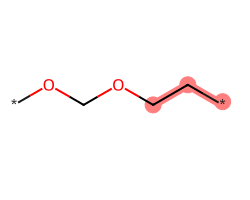

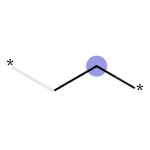

For Polymer
bit 80


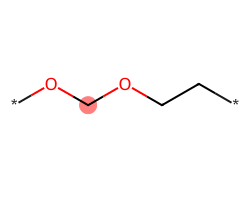

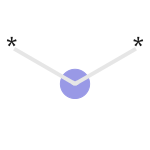

For Solvent
bit 846


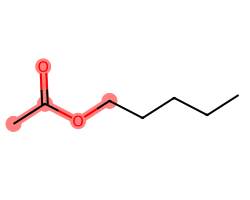

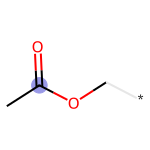

For Solvent
bit 147


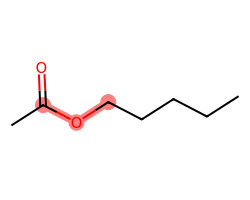

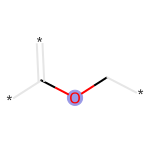

In [ ]:
#Draw top ranking Morgan fingerpirnt
from IPython.core.display import display

bits = [93, 80, "846*", "147*"]
for bit in bits:
  if type(bit) is int:
    print("For Polymer")
    pic1,pic2,_ = mf_poly.visualize(bit)
    display(pic1, pic2)
    
  else: 
    print("For Solvent")
    pic1,pic2,_ = mf_sol.visualize(int(bit[:-1]))
    display(pic1, pic2)